### Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

#### Alumno

Maximiliano Benítez Ahumada - A01752791


### Tweet Classification

El data set consiste de 10,000 tweets sobre desastres/accidentes. El objetivo es generar un modelo de Deep Learning capaz de identificar cuál de los tweets presenta un suceso real, y cuales no. En pocas palabras, se trata de un problema de NLP y clasificación binaria.

Se hará uso del modelo BERT para la clasificación.

El dataset está organizado de la siguiente manera:

Contienen:

- id
- keyword: Una palabra clave de ese tweet (Puede ser NaN).
- location: La ubicación desde donde se envió el (Puede ser NaN).
- text: El texto de un tweet.
- target: 1 si el tweet es un desastre real o 0 si es falso.

In [49]:
!pip install transformers

In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import keras_nlp

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


Using TensorFlow backend


Lectura del Dataset:

In [4]:
df_train = pd.read_csv("tweettrain.csv")
df_test = pd.read_csv("tweettest.csv")

print('Training Set Shape = {}'.format(df_train.shape))

print('Test Set Shape = {}'.format(df_test.shape))


Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [22]:
df_train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [21]:
df_test.head()

,id,keyword,location,text,length
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45


Creamos una nueva columna en ambos dataframes. Esta contiene la longitud de cada tweet.

In [5]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


Definimos nuestro parámetros:

In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 1
AUTO = tf.data.experimental.AUTOTUNE

Separamos nuestro dataset de entrenamiento para contar con uno de validación:

In [7]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

Previo a cargar el modelo BERT, debemos trasnformar las entradas de texto en identificadores numéricos de tokens. Posterior a esto, se organizan en varios tensores.

El modelo BertClassifier puede configurarse con una capa de preprocesamiento, en cuyo caso aplicará automáticamente el preprocesamiento a las entradas crudas durante fit(), predict() y evaluate(). Esto se hace por defecto al crear el modelo con from_preset().



Elegiremos el modelo DistilBERT, una versión resumida de BERT, conservando su rendimiento pero recortando el número de parámetros a la mitad.

In [ ]:
# Se elige el modelo en inglés y en minúsculas
preset= "distil_bert_base_en_uncased"


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Se elige una longitud de secuencia de textos debido a la naturaleza del dataset, puesto que estamos identificando tweets. La información relevante se encuentra en cadenas cortas de texto. Se eligió 128.

In [ ]:
# Se usa una secuencia corta (128)
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=128,
                                                                   name="preprocessor_4_tweets"
                                                                  )


# Clasificador pre entrenado.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)


classifier.summary()

Fine Tuning de BERT. Se elige un Learning Rate de 1e-6 debido al tamaño del dataset (10,000). Además, se toma en cuenta que la complejidad del problema no es muy elevada, puesto que se trata de clasificacion binaria en secuencias de texto cortas.

In [ ]:
import keras

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-6),  # Adjust the learning rate
    metrics=["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

191/191 [==============================] - 5362s 28s/step - loss: 0.6682 - accuracy: 0.6389 - val_loss: 0.6220 - val_accuracy: 0.7899


Obtuvimos una precisión de 0.63 y de 0.78 para el conjunto de validación. Se procederá al ajuste de parámetros para mejorar la precisión global.

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

### Segundo Modelo. Se busca la mejora de la precisión a través de los parámetros

Esta vez incrementaremos el número de épocas de 1 a 2, conservando el Batch Size en 32.

In [6]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

Ahora usaremos un tamaño de secuencia ligeramente mayor (160), en caso de que 128 no haya sido suficiente para permitir que el modelo distinga información relevante.

In [8]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"


# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )


# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)



classifier.summary()

265570304/265570304 [==============================] - 1s 0us/step


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

A su vez, incrementaremos el Learning Rate de 1e-6 a 1e-5 para mejorar la precisión global.

In [ ]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),  # Learning Rate
    metrics=["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 [==============================] - 6602s 34s/step - loss: 0.5027 - accuracy: 0.7583 - val_loss: 0.3888 - val_accuracy: 0.8477
Epoch 2/2
191/191 [==============================] - 6302s 33s/step - loss: 0.3732 - accuracy: 0.8468 - val_loss: 0.3797 - val_accuracy: 0.8457


Obtuvimos una precisión de 0.84 para ambos conjuntos. Se procederá al ajuste de learning rate para mejorar el modelo.

In [18]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

### Tercer Modelo. Se modifica nuevamente el learning rate a 1e-4.

Ya que se logró incrementar la precisión global con el ajuste anterior, agregaremos una capa de Dropout para combatir el overfitting que se presenta en dicha iteración.

In [35]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [36]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [37]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"


# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )


# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)



classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_21 (DistilBertTokenizer)     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone_21 (DistilBertBackbone)  │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_20 (SlicingOpLambda) │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-4),  # Adjust the learning rate
    metrics=["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 [==============================] - 6850s 36s/step - loss: 0.4447 - accuracy: 0.8046 - val_loss: 0.3972 - val_accuracy: 0.8352
Epoch 2/2
191/191 [==============================] - 6832s 36s/step - loss: 0.3042 - accuracy: 0.8818 - val_loss: 0.4289 - val_accuracy: 0.8181


Obtuvimos una precisión de 0.88 y de 0.81 para el conjunto de validación. Puesto que no hubo una mejora considerable, se procederá a usar nuestro learning rate anterior (1e-5) y modificar la capa de dropout para combatir el overfitting.

### Cuarto Modelo. Regresamos nuevamente el learning rate a 1e-5 y modificamos la capa de Dropout para que tenga una tasa de 0.7, comparado con el 0.5 predeterminado por Keras.

In [25]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [13]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"


# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )


# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)


nueva_tasa_dropout = 0.7


capa_dropout_existente = classifier.get_layer('classifier_dropout')

# Establece la nueva tasa de dropout en la capa existente
capa_dropout_existente.rate = nueva_tasa_dropout


classifier.summary()






Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_3 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone_3 (DistilBertBackbone)   │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_3 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Obtener la capa 'classifier_dropout' del modelo
dropout_layer = classifier.get_layer('classifier_dropout')

# Imprimir la información sobre la capa
print(dropout_layer)


In [16]:
import keras

In [17]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),  # Adjust the learning rate
    metrics=["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS ,
                         validation_data=(X_val, y_val){{{k}}}
                        )

Epoch 1/2
191/191 [==============================] - 5842s 31s/step - loss: 0.5202 - accuracy: 0.7573 - val_loss: 0.3992 - val_accuracy: 0.8398
Epoch 2/2
191/191 [==============================] - 5677s 30s/step - loss: 0.3904 - accuracy: 0.8438 - val_loss: 0.3820 - val_accuracy: 0.8483


191/191 [==============================] - 1672s 9s/step


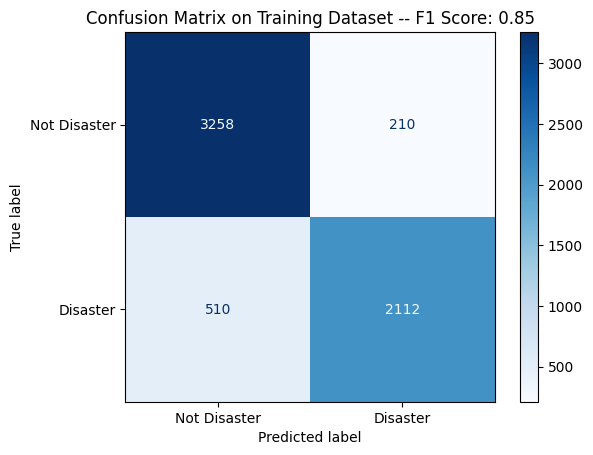

In [19]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 [==============================] - 417s 9s/step


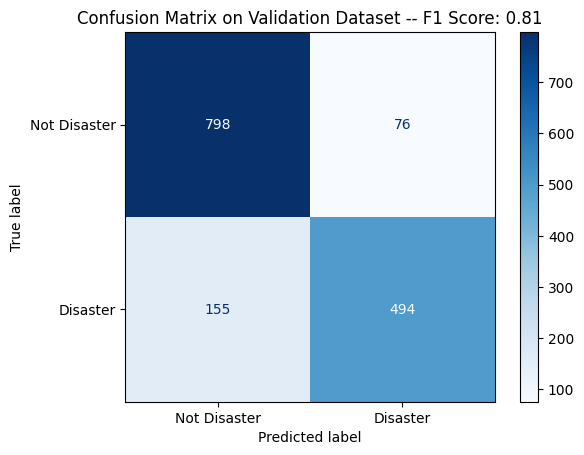

In [20]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

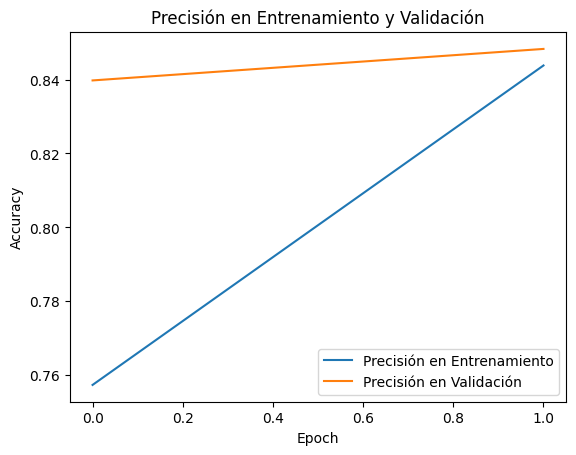

In [56]:
# Precisión en Entrenamiento y Validación
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.title('Precisión en Entrenamiento y Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



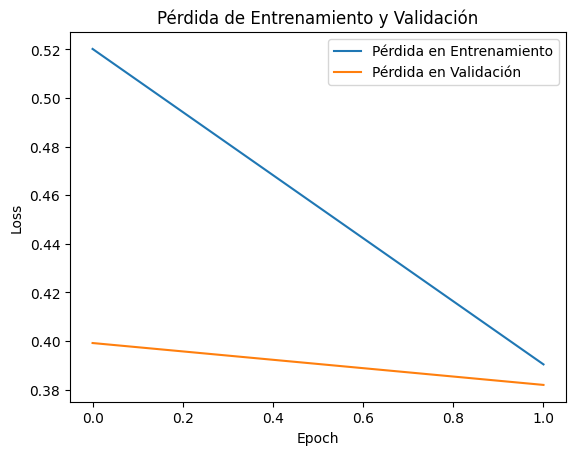

In [54]:
# Pérdida de Entrenamiento y Validación
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generar un archivo que contiene las predicciones del conjunto de Prueba; 1 si se trata de un desastre/accidente real, 0 si es falso.

In [120]:
sample_submission = pd.read_csv("output.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [121]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 [==============================] - 942s 9s/step


In [123]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [122]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.373276
std,3146.427221,0.483749
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [125]:
sample_submission.to_csv("output.csv", index=False)

### Generar nuevas predicciones con el modelo. Se usa un CSV con nuevos tweets creados con Chat GPT.

El csv contiene 26 tweets sobre desastres generados con Chat GPT.

In [127]:
new_prediction = pd.read_csv("new_tweets.csv")
new_prediction.head()

,category,text
0,0,Just happened a terrible car crash. My thought...
1,0,Reports of earthquakes in different cities are...
2,0,A forest fire at Spot Pond is a critical situa...
3,0,Apocalypse lighting in Spokane due to wildfire...
4,0,Typhoon Soudelor's impact on China and Taiwan ...


In [129]:
new_tweets = new_prediction["text"]

In [130]:
new_prediction["category"] = np.argmax(classifier.predict(new_tweets), axis=1)

1/1 [==============================] - 9s 9s/step


In [133]:
new_prediction

,category,text
0,1,Just happened a terrible car crash. My thought...
1,1,Reports of earthquakes in different cities are...
2,1,A forest fire at Spot Pond is a critical situa...
3,1,Apocalypse lighting in Spokane due to wildfire...
4,1,Typhoon Soudelor's impact on China and Taiwan ...
5,1,An earthquake is a frightening experience. Sta...
6,0,The situation at Birmingham Wholesale Market i...
7,1,Rape victim self-immolation is a tragic incide...
8,1,Accidents on the road can be dangerous. Please...
9,0,Burning oneself is a serious matter. If you or...


In [132]:
new_prediction.to_csv("predicted_tweets.csv", index=False)